## Modeling
Using combined news/tweet data from BuzzFeed, PolitiFact, GossipCop, COVID-19, Disasters. Unlike the FNID data, not all data has sources or titles. Also there are no dates included in this dataset. 

The goal in this notebook is to conduct binary classification to detect real/fake news. 

In [1]:
# general packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import re
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.stats import zscore
sns.set()

### Load Data

In [2]:
# load dataset
tweet_data = pd.read_csv('combined_tweets.csv', na_filter= False)

print(tweet_data.shape)
tweet_data.head()

(29052, 5)


,id,title,text,source,target
0,buzzfeed,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,www.addictinginfo.org,fake
1,buzzfeed,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,eaglerising.com,fake
2,buzzfeed,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,eaglerising.com,fake
3,buzzfeed,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",www.addictinginfo.org,fake
4,buzzfeed,Website is Down For Maintenance,Website is Down For Maintenance,www.proudcons.com,fake


In [4]:
# check null data
tweet_data.isnull().sum()

id        0
title     0
text      0
source    0
target    0
dtype: int64

<IPython.core.display.Javascript object>


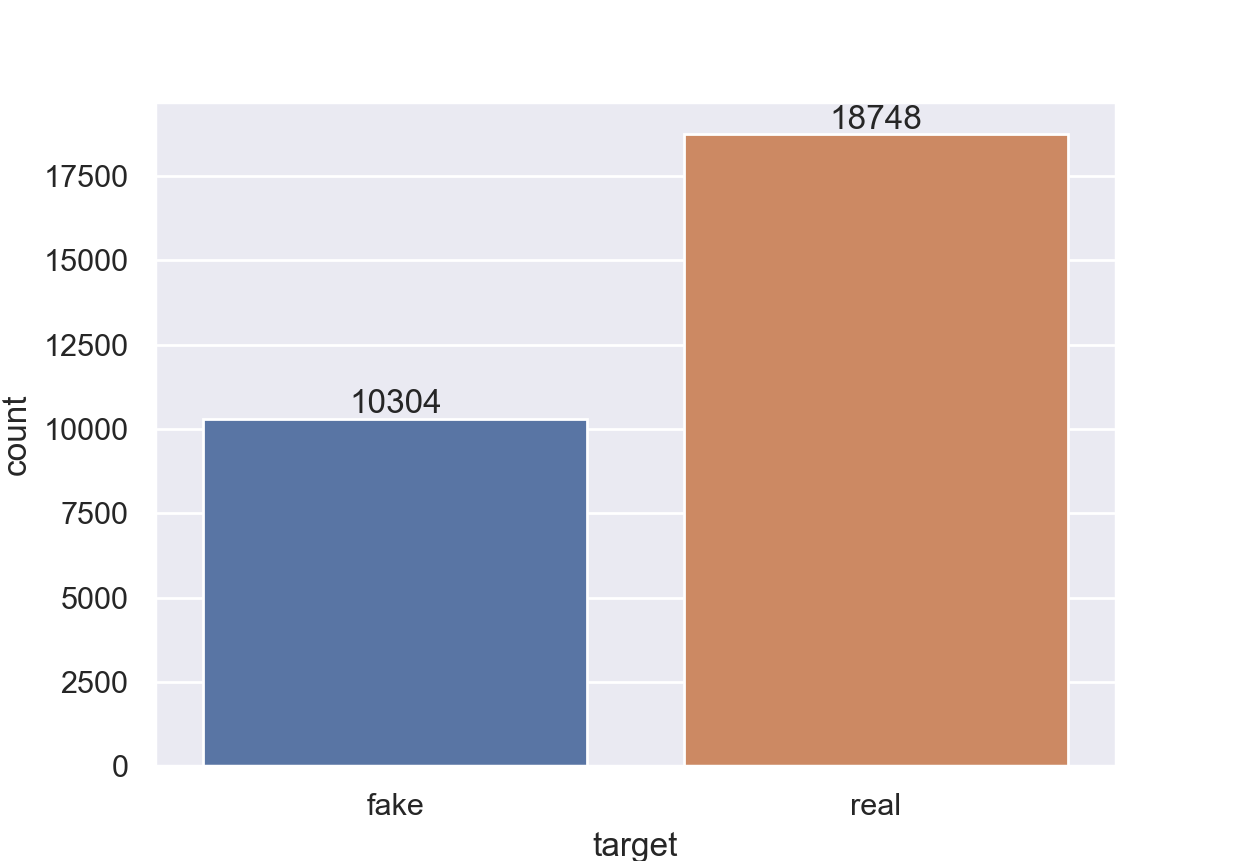

In [5]:
# check balance - make need to balance in modeling
ax=sns.countplot(x="target", data=tweet_data)
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), xy=(p.get_x()+p.get_width()/2, p.get_height()),
            xytext=(0, 5), textcoords='offset points', ha="center", va="center");

### Preprocessing

In [3]:
# import nlp packages
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# possible stop words
nltk_stop = set(stopwords.words('english'))
gensim_stop = set(STOPWORDS)

In [5]:
# remove url and html tag from text, emoji
# from: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [6]:
# clean up text functions
def process_text(df):
    # take url, html tags, emojis
    df['clean_text']=df['text'].apply(lambda x : remove_URL(x))
    df['clean_text']=df['clean_text'].apply(lambda x : remove_html(x))
    df['clean_text']=df['clean_text'].apply(lambda x : remove_emoji(x))
    # take trailing/leading spaces
    df["clean_text"] = df["clean_text"].str.strip()
     # remove punctuation
    df["clean_text"] = df["clean_text"].str.replace('[^ a-zA-Z]', '')
    df["clean_text"] = df["clean_text"].str.replace('[^\w\s]','')
    # lower case
    df["clean_text"] = df["clean_text"].str.lower()
    # take out stop words
    df["clean_text"] = df["clean_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (gensim_stop)]))
    # lemmatize and tokenize
    df["clean_text"] = df["clean_text"].apply(lambda x: token_text(x))
    
    # perform on article title
    df['clean_title']=df['title'].apply(lambda x : remove_URL(x))
    df['clean_title']=df['clean_title'].apply(lambda x : remove_html(x))
    df['clean_title']=df['clean_title'].apply(lambda x : remove_emoji(x))
    df["clean_title"] = df["clean_title"].str.strip()
    df["clean_title"] = df["clean_title"].str.replace('[^ a-zA-Z]', '')
    df["clean_title"] = df["clean_title"].str.replace('[^\w\s]','')
    df["clean_title"] = df["clean_title"].str.lower()
    df["clean_title"] = df["clean_title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (gensim_stop)]))
    # lemmatize and tokenize
    df["clean_title"] = df["clean_title"].apply(lambda x: token_text(x))
    return df

# tokenize and lemmatize
def token_text(article):
    lemmatizer = WordNetLemmatizer() 
    # tokenize
    words = word_tokenize(article)
    # lemmatize
    words = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return words    

In [7]:
# clean up dataframe
tweet_data_copy = tweet_data.copy()
tweet_data_copy.head()
tweet_data_copy = process_text(tweet_data_copy)
tweet_data_copy.head()

,id,title,text,source,target,clean_text,clean_title
0,buzzfeed,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,www.addictinginfo.org,fake,woke morning variation headline splashed news ...,proof mainstream medium manipulating election ...
1,buzzfeed,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,eaglerising.com,fake,president clinton clinton health access initia...,charity clinton foundation distributed watered...
2,buzzfeed,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,eaglerising.com,fake,collapsing trying step van removed ceremony ne...,hillary clinton administration entirely run fi...
3,buzzfeed,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",www.addictinginfo.org,fake,donald trump deplorable he suggested building ...,trump latest campaign promise horrible
4,buzzfeed,Website is Down For Maintenance,Website is Down For Maintenance,www.proudcons.com,fake,website maintenance,website maintenance


In [8]:
# encode target
labels=['fake','real']
tweet_data_copy['news_class'] = np.where(tweet_data_copy['target']=='fake', 0, 1)

tweet_data_copy.head()

,id,title,text,source,target,clean_text,clean_title,news_class
0,buzzfeed,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,www.addictinginfo.org,fake,woke morning variation headline splashed news ...,proof mainstream medium manipulating election ...,0
1,buzzfeed,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,eaglerising.com,fake,president clinton clinton health access initia...,charity clinton foundation distributed watered...,0
2,buzzfeed,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,eaglerising.com,fake,collapsing trying step van removed ceremony ne...,hillary clinton administration entirely run fi...,0
3,buzzfeed,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",www.addictinginfo.org,fake,donald trump deplorable he suggested building ...,trump latest campaign promise horrible,0
4,buzzfeed,Website is Down For Maintenance,Website is Down For Maintenance,www.proudcons.com,fake,website maintenance,website maintenance,0


In [9]:
# save data for modeling
tweet_data_copy.to_csv('tweet_data_modeling.csv') 

# tweet_data_copy = pd.read_csv('tweet_data_modeling.csv')

In [10]:
# X and y data - merge title and text
tweet_data_copy['combined_text'] = tweet_data_copy['clean_title'] + ' ' + tweet_data_copy['clean_text']
tweet_data_copy['combined_text'] = tweet_data_copy["combined_text"].str.strip()
tweet_data_copy['combined_text'] = tweet_data_copy['combined_text'].str.replace('\n','')

X = tweet_data_copy['combined_text'].values.astype('str')
y = tweet_data_copy['news_class']

X[:2]

array(['proof mainstream medium manipulating election taking clinton context woke morning variation headline splashed news feedbill clinton natural foundation donor seek favorsheres googlenaturally reaction oh st clinton damage wife campaign nowof course headline sound awful play right idea clinton foundation pay play like donald trump saying unfortunately take reading headline people dont real story real story pay playit natural people whove political ally personal friend ask thing trusted state department wouldnt shouldnt clinton told npr interview aired monday morning source cnnin word people ask favor certainly doesnt mean theyll leaked email shown clinton foundation donor gotten meeting clinton turned zero evidence pay play word people asked favor there evidence got themnow let talk foundation medium doesnt like mention trump foundation trump given foundation collect money give take charity allegedly buy thing like oil painting football helmet charity moneynew york attorney genera

In [11]:
# train test split
from sklearn.model_selection import train_test_split

In [13]:
# train/test split
trainX, testX, trainY, testY = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

In [14]:
print(trainX.shape)
print(testY.shape)

(23241,)
(5811,)


### Modeling

In [12]:
# load model preprocessing 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [13]:
# load model packages
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [14]:
# create function to train and report metrics
def fit_model(model, X, y, cv=5, scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']):
    model.fit(X, y)
    preds = model.predict(X)
    print('Training Metrics: ')
    print(metrics.classification_report(y, preds))
    # cross validation
    cv_scores = cross_validate(model, X, y, scoring=scoring, cv=cv)
    print('Cross Validation (CV) Metrics:')
    print('Average CV Accuracy: ', cv_scores['test_accuracy'].mean())
    print('Average CV Precision: ', cv_scores['test_precision_macro'].mean())
    print('Average CV Recall: ', cv_scores['test_recall_macro'].mean())
    print('Average CV F1 Score: ', cv_scores['test_f1_macro'].mean())

# test metrics
def test_metrics(model, X, y, labels):
    preds = model.predict(X)
    print('Testing Metrics: ')
    print(metrics.classification_report(y, preds))
    
    # confusion matrix 
    cm = metrics.confusion_matrix(y, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # plot confusion matrix (normalized)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.heatmap(cm_norm, annot=True, cmap="Blues", annot_kws={"fontsize":10}, ax=ax[0])
    ax[0].set_xlabel('Predicted', fontsize=8)
    ax[0].set_ylabel('Actual', fontsize=8)
    ax[0].set_title('Normalized Confusion Matrix', fontsize=12, pad=12)
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)
    
    # roc curve 
    fpr, tpr, _ = metrics.roc_curve(y, preds)
    ax[1].plot(fpr, tpr)
    ax[1].plot([0,1], [0,1], linestyle='--')
    ax[1].set_xlabel('False Positive Rate', fontsize=8)
    ax[1].set_ylabel('True Positive Rate', fontsize=8)
    ax[1].set_title('ROC Curve', fontsize=12, pad=12)
    fig.tight_layout()

#### Logistic Regression

In [19]:
# fit general logistic model - unbalanced
pipe_lr = Pipeline([('tfidf', TfidfVectorizer()), 
                    ('lr', LogisticRegression( random_state=42))])
fit_model(pipe_lr, trainX, trainY)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      8240
           1       0.88      0.96      0.92     15001

    accuracy                           0.89     23241
   macro avg       0.89      0.86      0.87     23241
weighted avg       0.89      0.89      0.89     23241



/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8112816166488157
Average CV Precision:  0.8091058928981996
Average CV Recall:  0.7677986982224911
Average CV F1 Score:  0.7807836253606257


In [21]:
# logistic regression - tune
lr_params = {'tfidf__max_df': (0.70, 0.80, 0.90),
             'lr__penalty': ('l1','l2')}

lr_search = RandomizedSearchCV(pipe_lr, param_distributions=lr_params,
                                   cv=3, random_state=42, return_train_score=True)
lr_search.fit(trainX, trainY)

print("Best Hyperparameters:",lr_search.best_params_)
print("Best CV score is {}".format(lr_search.best_score_))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Hyperparameters: {'tfidf__max_df': 0.7, 'lr__penalty': 'l2'}
Best CV score is 0.8056021685813863


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.80      0.62      0.70      2064
           1       0.81      0.91      0.86      3747

    accuracy                           0.81      5811
   macro avg       0.81      0.77      0.78      5811
weighted avg       0.81      0.81      0.80      5811



<IPython.core.display.Javascript object>


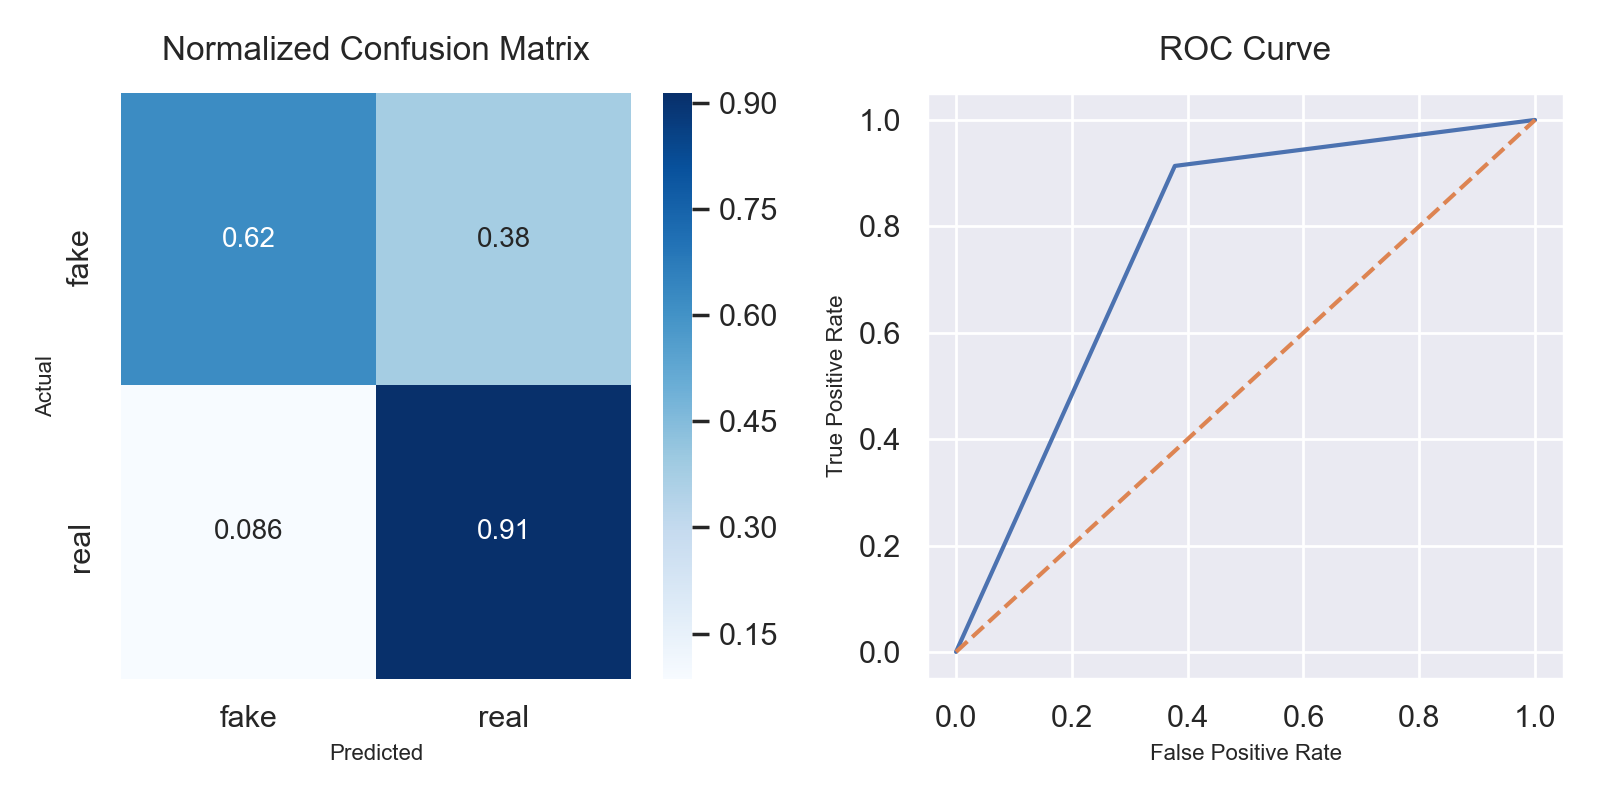

In [22]:
# test metrics logistitic regression
test_metrics(lr_search.best_estimator_, testX, testY, labels)

In [23]:
# vectorize on one percentage for rest of modeling
tfidf_vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(trainX) 
tfidf_test = tfidf_vectorizer.transform(testX)

#### Naive Bayes

In [27]:
# naive bayes classifier (multinomial) - unbalanced
nb = MultinomialNB()
fit_model(nb, tfidf_train, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.18      0.30      8240
           1       0.69      1.00      0.82     15001

    accuracy                           0.71     23241
   macro avg       0.84      0.59      0.56     23241
weighted avg       0.79      0.71      0.63     23241

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.6715286984523535
Average CV Precision:  0.7900727855995141
Average CV Recall:  0.5384400787116268
Average CV F1 Score:  0.4726075319162376


#### Passive Agressive Classifier

In [28]:
# passive aggressive classifier - unbalanced
pa = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa, tfidf_train, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8240
           1       0.99      0.99      0.99     15001

    accuracy                           0.99     23241
   macro avg       0.99      0.99      0.99     23241
weighted avg       0.99      0.99      0.99     23241

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7857234950310413
Average CV Precision:  0.7666551853259602
Average CV Recall:  0.7618658604629094
Average CV F1 Score:  0.763869634070877


#### Random Forest

In [30]:
# random forest classifier - unbalanced
rf = RandomForestClassifier(random_state=42)
fit_model(rf, tfidf_train, trainY, 3)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8240
           1       0.99      0.99      0.99     15001

    accuracy                           0.99     23241
   macro avg       0.98      0.98      0.98     23241
weighted avg       0.99      0.99      0.99     23241

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.760466947650428
Average CV Precision:  0.7408944183198374
Average CV Recall:  0.7208609574974636
Average CV F1 Score:  0.7278358962928122


In [31]:
# RF - tune (took a long time to run)
rf_params = {'n_estimators': [50, 75, 100, 200], 
                  'max_features': ['auto', 'sqrt', 'log2', None], 
                  'max_depth': [5,6,8,10, None]}


rf_search = RandomizedSearchCV(rf, param_distributions=rf_params,
                                   cv=3, random_state=42, return_train_score=True)
rf_search.fit(tfidf_train, trainY)

print("Best Hyperparameters:",rf_search.best_params_)
print("Best CV score is {}".format(rf_search.best_score_))

Best Hyperparameters: {'n_estimators': 100, 'max_depth': None}
Best CV score is 0.7844757110279248


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.79      0.54      0.64      2064
           1       0.78      0.92      0.85      3747

    accuracy                           0.79      5811
   macro avg       0.79      0.73      0.74      5811
weighted avg       0.79      0.79      0.77      5811



<IPython.core.display.Javascript object>


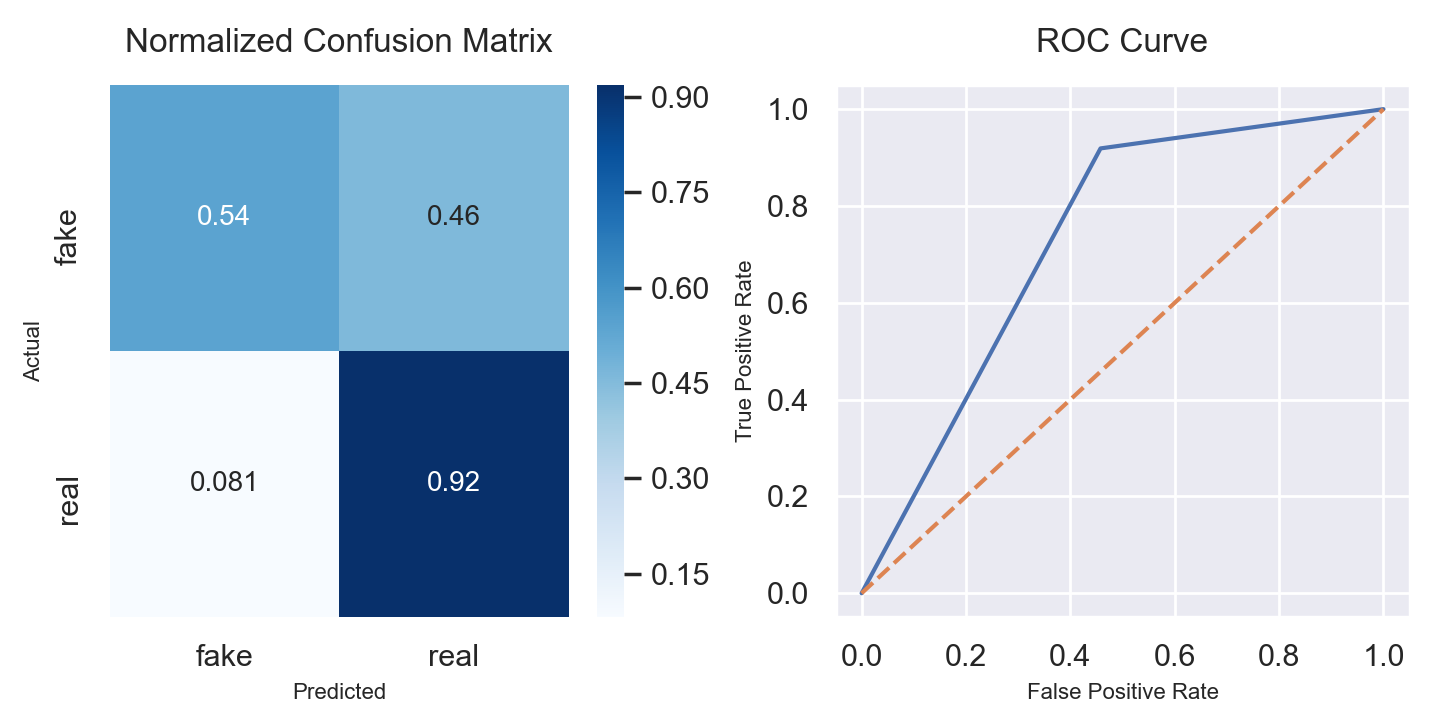

In [33]:
# test metrics RF
test_metrics(rf_search.best_estimator_, tfidf_test, testY, labels)

#### Boosting
Gradient Boosting and XGBoost

In [34]:
# gradient boosting classifier - tuning takes a while on this data - unbalanced (tuning timed out)
gb = GradientBoostingClassifier(random_state=42)
fit_model(gb, tfidf_train, trainY,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.86      0.35      0.49      8240
           1       0.73      0.97      0.83     15001

    accuracy                           0.75     23241
   macro avg       0.80      0.66      0.66     23241
weighted avg       0.78      0.75      0.71     23241

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7277654614492999
Average CV Precision:  0.7615568854454149
Average CV Recall:  0.6324610087592224
Average CV F1 Score:  0.631191951119274


In [35]:
# xgb classifier - tuning takes a while on this data - unbalanced (tuning timed out)
xgb = xgb.XGBClassifier(random_state=42)
fit_model(xgb, tfidf_train, trainY,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      8240
           1       0.89      0.92      0.90     15001

    accuracy                           0.87     23241
   macro avg       0.86      0.86      0.86     23241
weighted avg       0.87      0.87      0.87     23241

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7921343485935161
Average CV Precision:  0.7755606846189304
Average CV Recall:  0.7619095216918813
Average CV F1 Score:  0.7674806179102749


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      2064
           1       0.82      0.87      0.85      3747

    accuracy                           0.80      5811
   macro avg       0.78      0.77      0.77      5811
weighted avg       0.79      0.80      0.79      5811



<IPython.core.display.Javascript object>


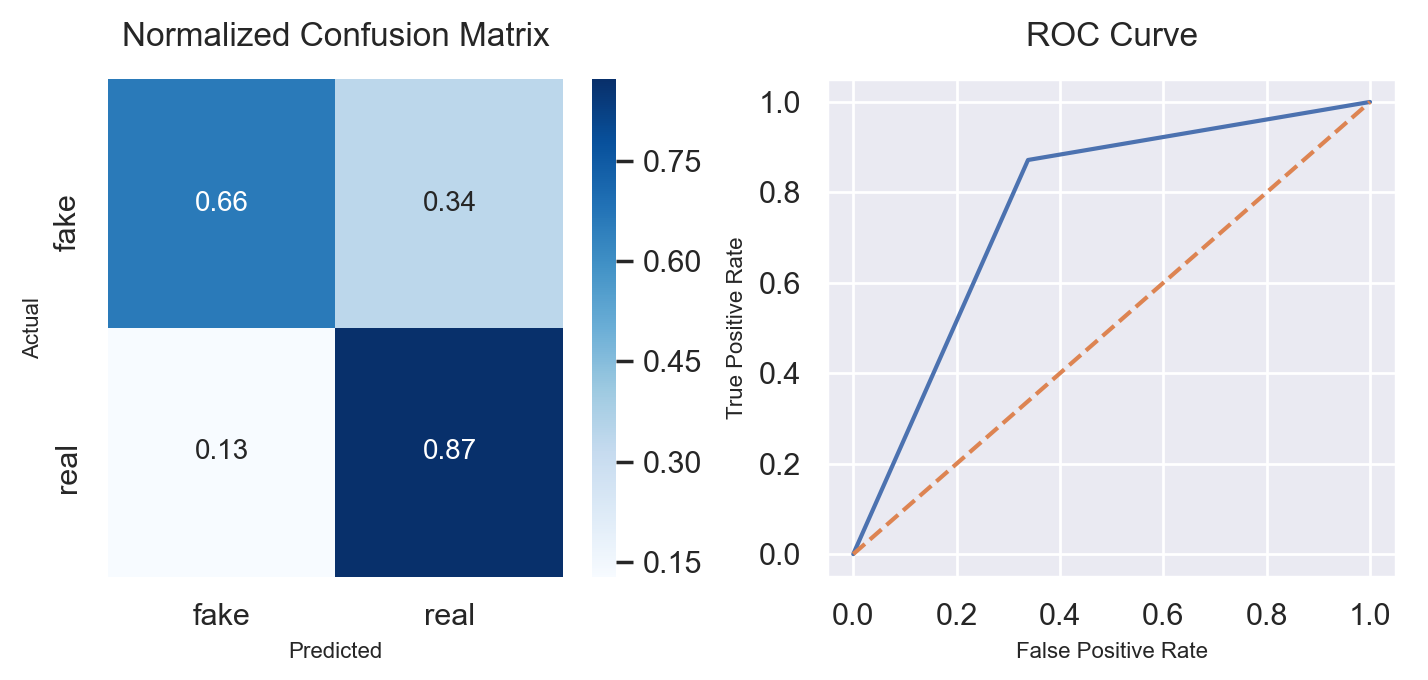

In [44]:
# test metric xgb
test_metrics(xgb, tfidf_test, testY, labels)

### Balanced Dataset

In [15]:
# balance data and run logistic, passive aggressive, Naive Bayes, rf, xgb
from sklearn.utils import resample

# undersample
df_majority = tweet_data_copy[tweet_data_copy.news_class==1]
df_minority = tweet_data_copy[tweet_data_copy.news_class==0]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=10304, random_state=123)

df_balance = pd.concat([df_majority_downsampled, df_minority])
df_balance['news_class'].value_counts()

1    10304
0    10304
Name: news_class, dtype: int64

In [37]:
df_balance.head()

,id,title,text,source,target,clean_text,clean_title,news_class,combined_text
27616,gossipcop-942635,Anthony Bourdain's Ex Paula Froelich Calls Him...,Sharing her sorrow. Following the news of Anth...,https://www.usmagazine.com,real,sharing sorrow following news anthony bourdain...,anthony bourdains ex paula froelich call loyal...,1,anthony bourdains ex paula froelich call loyal...
24326,gossipcop-907763,Tracee Ellis Ross's SAG Awards Joke Actually M...,While the SAG Awards red carpet was noticeably...,https://guestofaguest.com,real,sag award red carpet noticeably devoid fashion...,tracee elli ross sag award joke actually impor...,1,tracee elli ross sag award joke actually impor...
15707,gossipcop-888688,Here's When You Can Watch Star Trek: Discovery...,Here's When You Can Watch Star Trek: Discovery...,https://www.cbs.com,real,here watch star trek discovery season plus bra...,here watch star trek discovery season,1,here watch star trek discovery season here wat...
27477,gossipcop-903233,Kourtney and Kim Kardashian Compete in a 'Swea...,The Kardashian women are willing to do just ab...,https://www.glamour.com,real,kardashian woman willing look feel best know t...,kourtney kim kardashian compete sweat test who...,1,kourtney kim kardashian compete sweat test who...
21369,gossipcop-900681,Camille Grammer Opens Up About Second Cancer D...,RHOBH's Camille Grammer tells PEOPLE exclusive...,https://people.com,real,rhobhs camille grammer tell people exclusively...,camille grammer open second cancer diagnosis s...,1,camille grammer open second cancer diagnosis s...


In [16]:
# split balanced data into target and features 
X_bal, y_bal = df_balance['combined_text'].values.astype('str'), df_balance['news_class']
X_bal[0]

'anthony bourdains ex paula froelich call loyal love death sharing sorrow following news anthony bourdains death friday june exgirlfriend paula froelich spoke outthe yearold journalist dated bourdain month early according yahoo took twitter share thought series emotional tweetsheres thing depression sneaky little sticky btch rich hell totally successful lonely af youre fraud voice go away ambien take effect wrote followed lengthy discussion medication mental illnessshe concluded heart knowing best funniest loveliest empathetic wonderful talented people depression youre good crowd let fight black dog togetherfroelich posted photo instagram reflecting boyfriend life shared sweet memory twoto good man great friend loyal love captioned picture bourdain smiling thats im going saythe post came hour news broke part unknown host dead apparent suicide age cnn reported broadcast friday morning hanged himselffroelich isnt close tv personality quickly took social medium share sadness bourdains gir

In [39]:
y_bal[0]

0

In [17]:
# train/test split - balanced
trainX_bal, testX_bal, trainY_bal, testY_bal = train_test_split(X_bal, y_bal, train_size=0.8, random_state=42, shuffle=True)

In [18]:
# vectorize at 70% for rest of models (based on previous performance)
tfidf_vectorizer_bal = TfidfVectorizer(max_df=0.7)
tfidf_train_bal = tfidf_vectorizer_bal.fit_transform(trainX_bal) 
tfidf_test_bal = tfidf_vectorizer_bal.transform(testX_bal)

In [23]:
# logistic regression - balance
lr_bal = LogisticRegression(solver='lbfgs', random_state=42)
fit_model(lr_bal, tfidf_train_bal, trainY_bal)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      8254
           1       0.89      0.88      0.88      8232

    accuracy                           0.88     16486
   macro avg       0.88      0.88      0.88     16486
weighted avg       0.88      0.88      0.88     16486

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7974025964569561
Average CV Precision:  0.7976981338485218
Average CV Recall:  0.7973836117806038
Average CV F1 Score:  0.7973434890604435


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2050
           1       0.80      0.82      0.81      2072

    accuracy                           0.80      4122
   macro avg       0.80      0.80      0.80      4122
weighted avg       0.80      0.80      0.80      4122



<IPython.core.display.Javascript object>


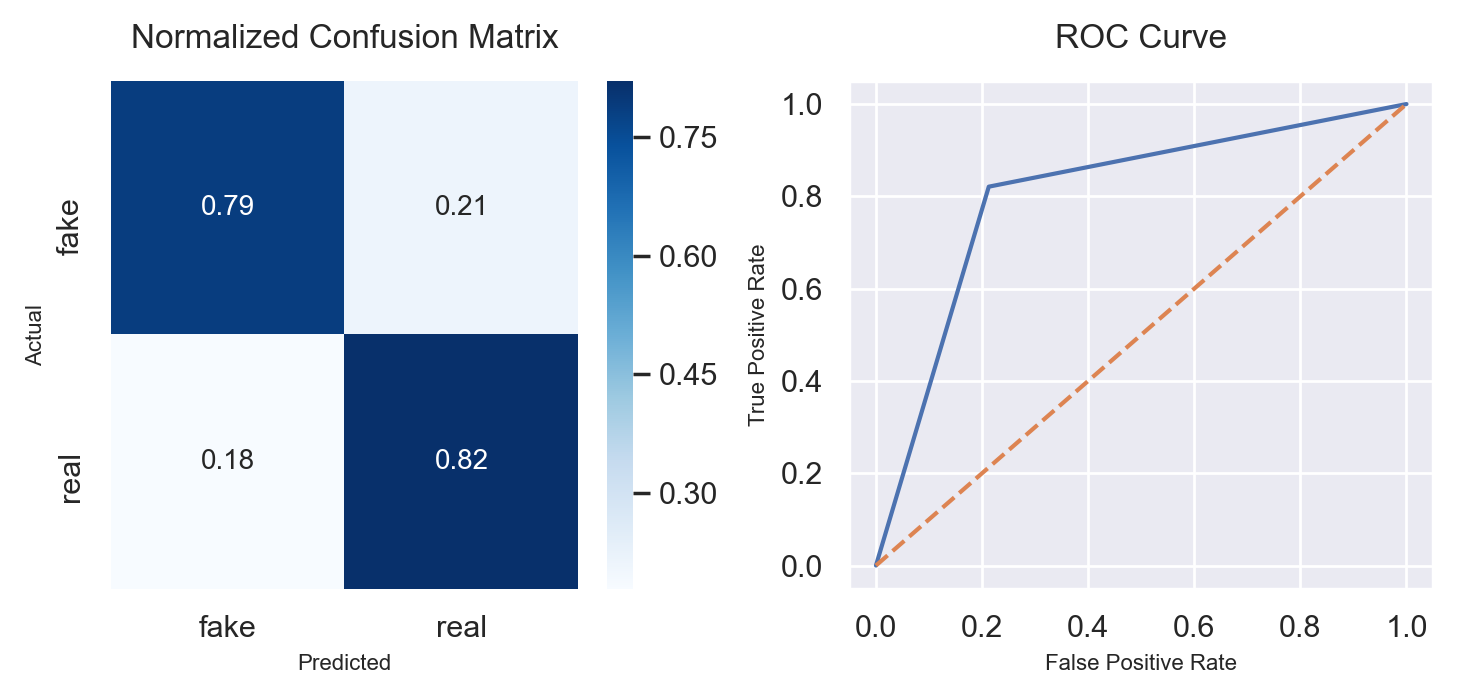

In [24]:
# logistic regression - test
test_metrics(lr_bal, tfidf_test_bal, testY_bal, labels)

In [29]:
# roc - logistic balance
lr_bal_preds_test = lr_bal.predict(tfidf_test_bal)
metrics.roc_auc_score(lr_bal_preds_test, testY_bal)

0.8045369517992336

In [33]:
# naive bayes - balance
nb_bal = MultinomialNB()
fit_model(nb_bal, tfidf_train_bal, trainY_bal)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      8254
           1       0.79      0.95      0.86      8232

    accuracy                           0.85     16486
   macro avg       0.86      0.85      0.85     16486
weighted avg       0.86      0.85      0.85     16486

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7531228195252442
Average CV Precision:  0.7774038826468661
Average CV Recall:  0.7533183766178666
Average CV F1 Score:  0.7476825254923328


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.88      0.60      0.71      2050
           1       0.70      0.92      0.79      2072

    accuracy                           0.76      4122
   macro avg       0.79      0.76      0.75      4122
weighted avg       0.79      0.76      0.75      4122



<IPython.core.display.Javascript object>


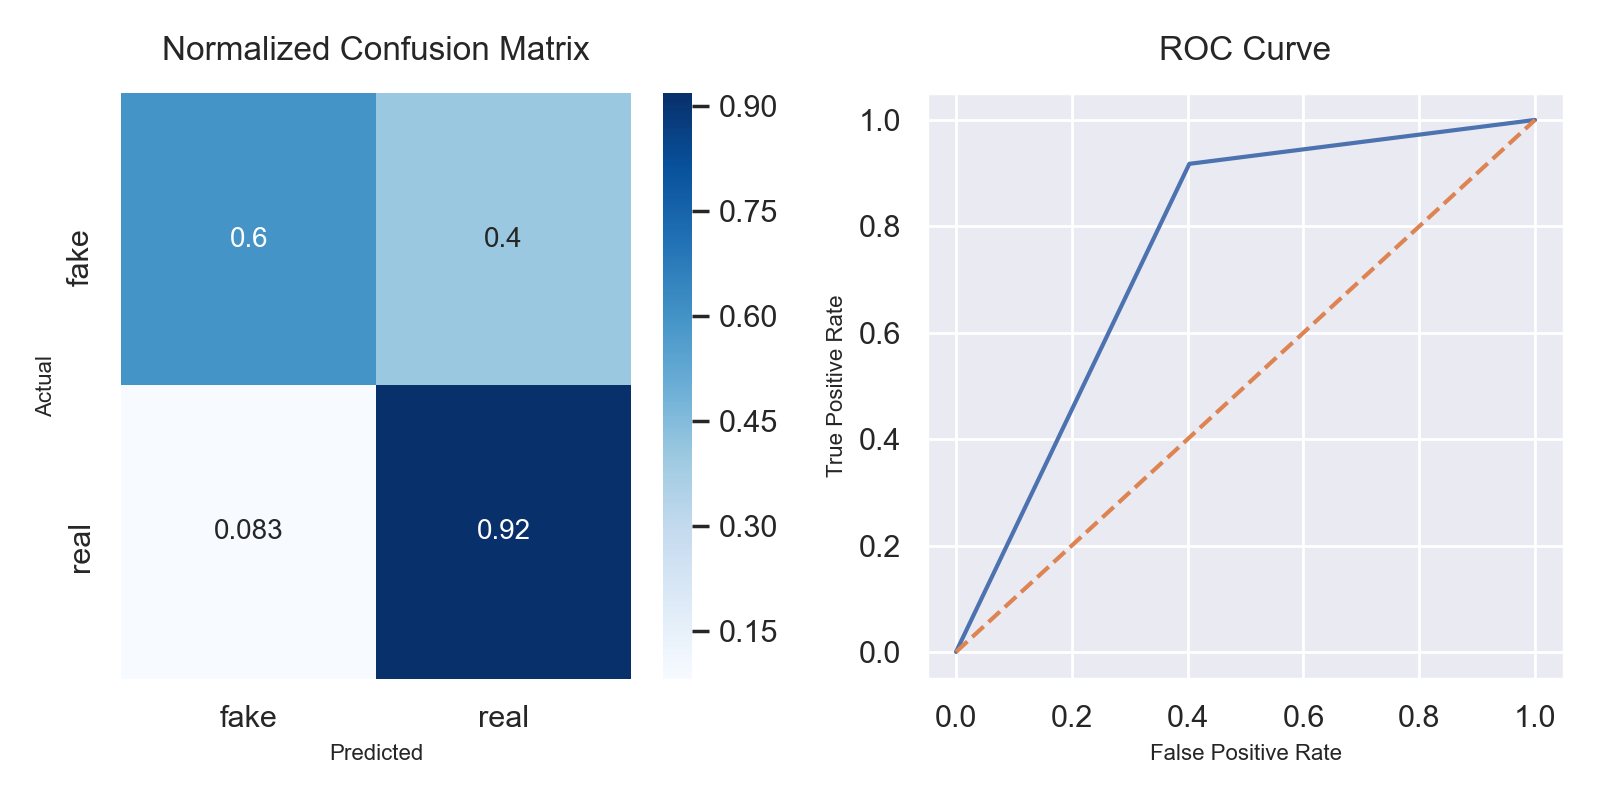

In [34]:
# NB - test
test_metrics(nb_bal, tfidf_test_bal, testY_bal, labels)

In [35]:
# roc - Naive Bayes balance
nb_bal_preds_test = nb_bal.predict(tfidf_test_bal)
metrics.roc_auc_score(nb_bal_preds_test, testY_bal)

0.7872611992382035

In [25]:
# passive aggressive - balance
pa_bal = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa_bal, tfidf_train_bal, trainY_bal)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8254
           1       0.99      0.99      0.99      8232

    accuracy                           0.99     16486
   macro avg       0.99      0.99      0.99     16486
weighted avg       0.99      0.99      0.99     16486

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7658002213544581
Average CV Precision:  0.7659484344589902
Average CV Recall:  0.7658035171053961
Average CV F1 Score:  0.7657690384341033


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      2050
           1       0.75      0.78      0.77      2072

    accuracy                           0.76      4122
   macro avg       0.76      0.76      0.76      4122
weighted avg       0.76      0.76      0.76      4122



<IPython.core.display.Javascript object>


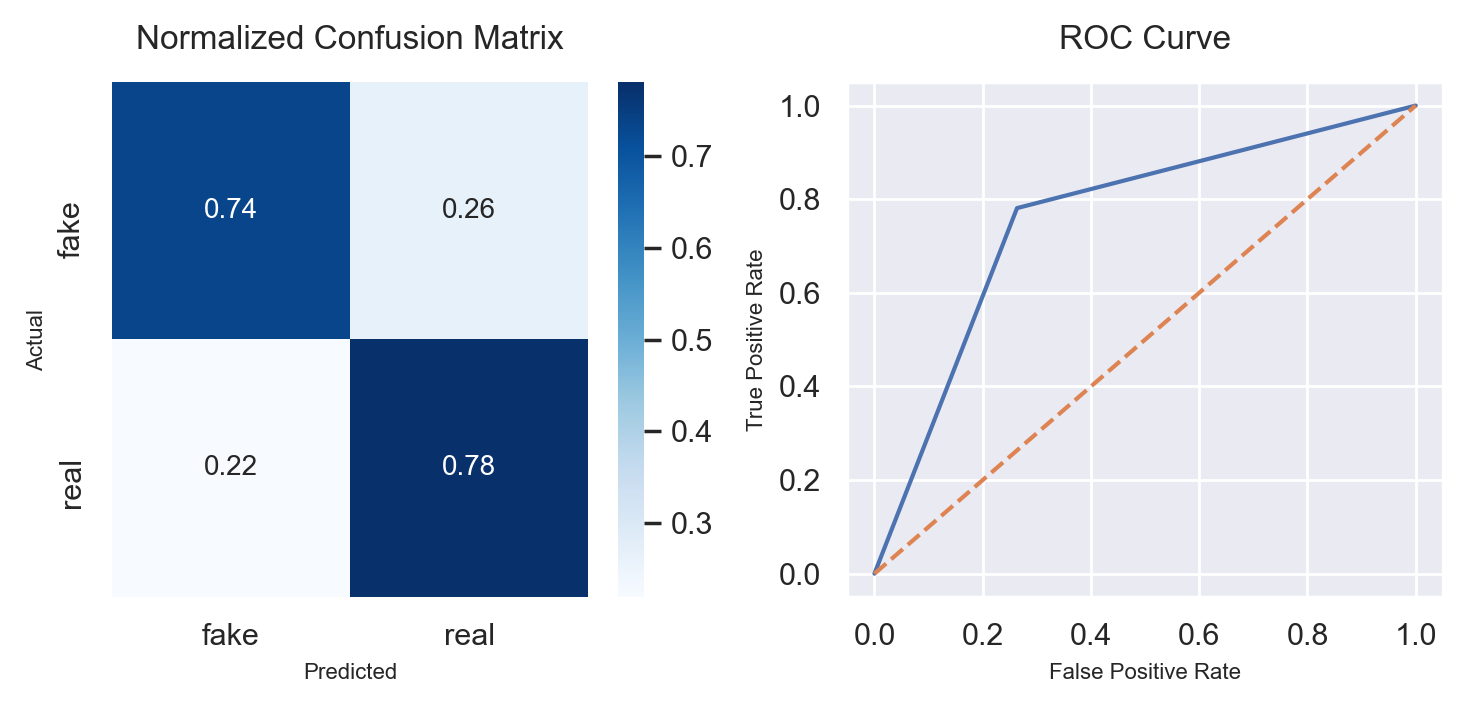

In [26]:
# passive aggressive - test
test_metrics(pa_bal, tfidf_test_bal, testY_bal, labels)

In [30]:
# roc - passive aggressive balance
pa_bal_preds_test = pa_bal.predict(tfidf_test_bal)
metrics.roc_auc_score(pa_bal_preds_test, testY_bal)

0.7593037039274126

In [19]:
# random forest - balance - used previous result to inform
rf_bal = RandomForestClassifier(n_estimators=100, random_state=42)
fit_model(rf_bal, tfidf_train_bal, trainY_bal, 3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8254
           1       0.99      0.99      0.99      8232

    accuracy                           0.99     16486
   macro avg       0.99      0.99      0.99     16486
weighted avg       0.99      0.99      0.99     16486

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7636780978164173
Average CV Precision:  0.7654403702291597
Average CV Recall:  0.7637289006482865
Average CV F1 Score:  0.7633085618187191


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      2050
           1       0.76      0.84      0.80      2072

    accuracy                           0.78      4122
   macro avg       0.79      0.78      0.78      4122
weighted avg       0.79      0.78      0.78      4122



<IPython.core.display.Javascript object>


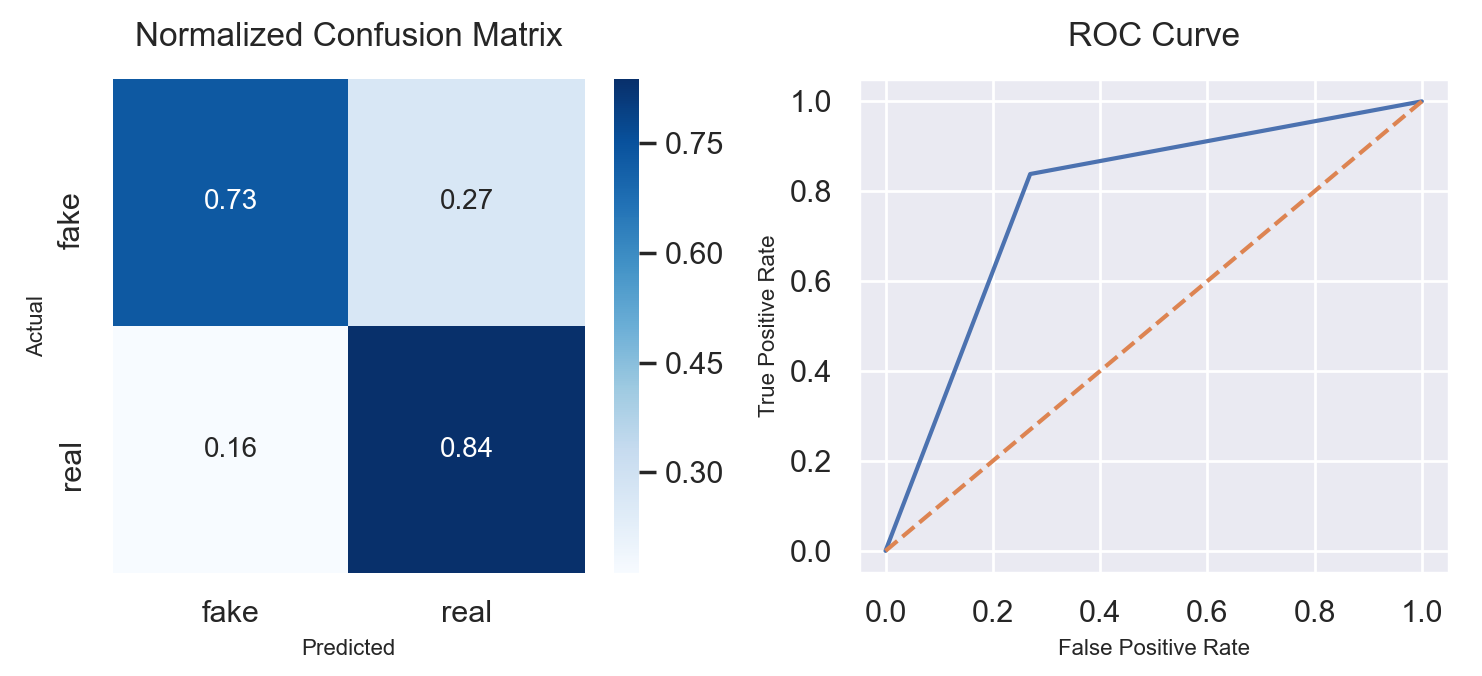

In [20]:
# random forest - test
test_metrics(rf_bal, tfidf_test_bal, testY_bal, labels)

In [31]:
# roc - rf balance
rf_bal_preds_test = rf_bal.predict(tfidf_test_bal)
metrics.roc_auc_score(rf_bal_preds_test, testY_bal)

0.7878275109170305

In [21]:
# xgb - balance
xgb_bal = xgb.XGBClassifier(random_state=42)
fit_model(xgb_bal, tfidf_train_bal, trainY_bal,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8254
           1       0.92      0.83      0.88      8232

    accuracy                           0.88     16486
   macro avg       0.89      0.88      0.88     16486
weighted avg       0.89      0.88      0.88     16486

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7688339251553726
Average CV Precision:  0.7702014546072209
Average CV Recall:  0.7687865129662476
Average CV F1 Score:  0.7685181360280886


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      2050
           1       0.79      0.74      0.77      2072

    accuracy                           0.77      4122
   macro avg       0.77      0.77      0.77      4122
weighted avg       0.77      0.77      0.77      4122



<IPython.core.display.Javascript object>


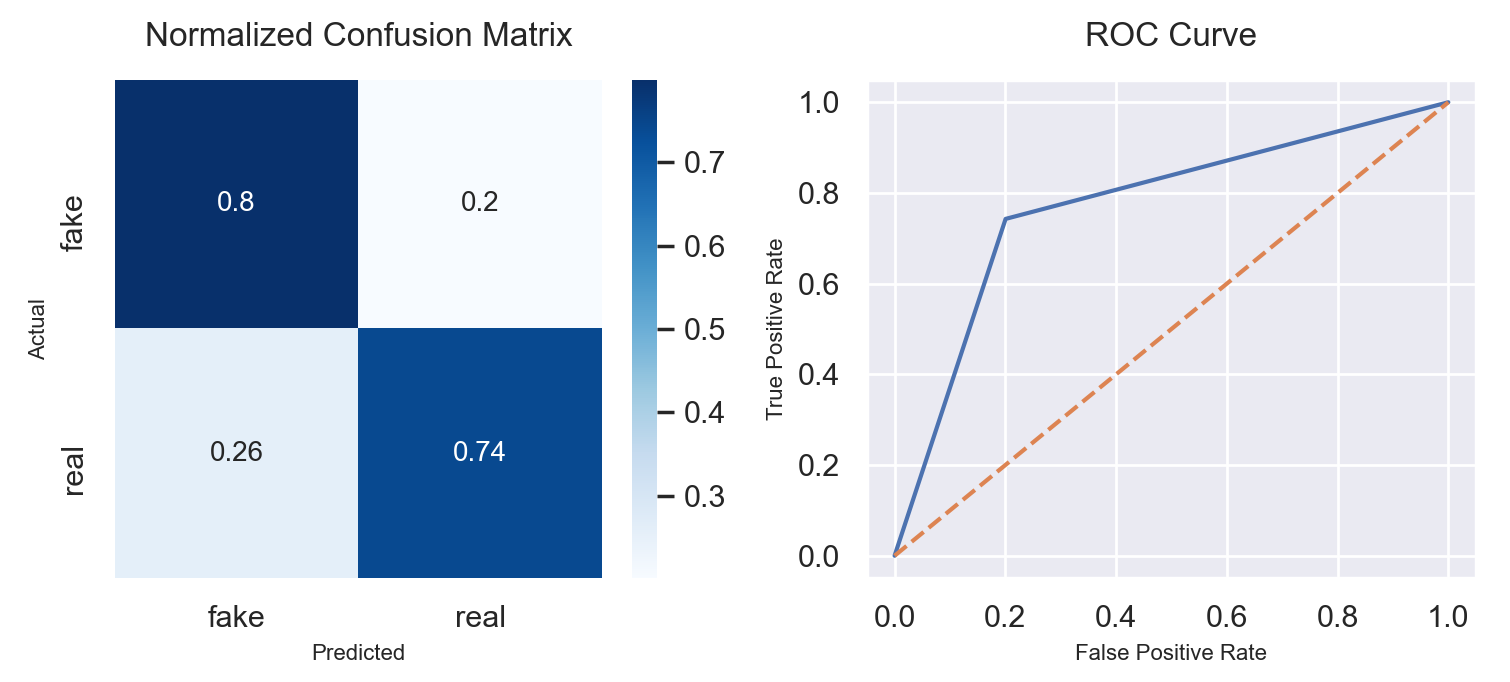

In [22]:
# xgb - test (tried tuning but kept timing out)
test_metrics(xgb_bal, tfidf_test_bal, testY_bal, labels)

In [32]:
# roc - xgb balance
xgb_bal_preds_test = xgb_bal.predict(tfidf_test_bal)
metrics.roc_auc_score(xgb_bal_preds_test, testY_bal)

0.7719174103980734